In [11]:
from Bio.Data import CodonTable

# Get the standard codon table
table = CodonTable.unambiguous_dna_by_name["Standard"]

# Get mappings
codon_to_aa = table.forward_table.copy()
# Add stop codons manually (Biopython doesn’t include them in forward_table)
for stop in table.stop_codons:
    codon_to_aa[stop] = "*"

bases = ["A", "C", "G", "T"]

results = []

for codon, aa in codon_to_aa.items():
    synonymous = 0
    to_stop = 0
    total_single_changes = 0

    # Iterate through all single-base substitutions
    for pos in range(3):  # positions 0, 1, 2
        for b in bases:
            if b == codon[pos]:
                continue
            mutated = codon[:pos] + b + codon[pos+1:]
            if mutated not in codon_to_aa:
                continue
            total_single_changes += 1
            new_aa = codon_to_aa[mutated]
            if new_aa == "*":
                to_stop += 1
            elif new_aa == aa:
                synonymous += 1

    results.append({
        "codon": codon,
        "aa": aa,
        "synonymous_changes": synonymous,
        "stop_changes": to_stop,
        "total_possible_changes": total_single_changes
    })

# Sort results by amino acid, then codon
results.sort(key=lambda x: (x["aa"], x["codon"]))

# Print summary
print(f"{'Codon':<6} {'AA':<3} {'Syn':<4} {'Stop':<4} {'Total':<5}")
for r in results:
    print(f"{r['codon']:<6} {r['aa']:<3} {r['synonymous_changes']:<4} {r['stop_changes']:<4} {r['total_possible_changes']:<5}")


Codon  AA  Syn  Stop Total
TAA    *   0    2    9    
TAG    *   0    1    9    
TGA    *   0    1    9    
GCA    A   3    0    9    
GCC    A   3    0    9    
GCG    A   3    0    9    
GCT    A   3    0    9    
TGC    C   1    1    9    
TGT    C   1    1    9    
GAC    D   1    0    9    
GAT    D   1    0    9    
GAA    E   1    1    9    
GAG    E   1    1    9    
TTC    F   1    0    9    
TTT    F   1    0    9    
GGA    G   3    1    9    
GGC    G   3    0    9    
GGG    G   3    0    9    
GGT    G   3    0    9    
CAC    H   1    0    9    
CAT    H   1    0    9    
ATA    I   2    0    9    
ATC    I   2    0    9    
ATT    I   2    0    9    
AAA    K   1    1    9    
AAG    K   1    1    9    
CTA    L   4    0    9    
CTC    L   3    0    9    
CTG    L   4    0    9    
CTT    L   3    0    9    
TTA    L   2    2    9    
TTG    L   2    1    9    
ATG    M   0    0    9    
AAC    N   1    0    9    
AAT    N   1    0    9    
CCA    P   3    0    9    
C

In [13]:
from Bio.Data import CodonTable
import pandas as pd
from itertools import product

# Standard codon table
table = CodonTable.unambiguous_dna_by_name["Standard"]
codon_to_aa = table.forward_table.copy()
for stop in table.stop_codons:
    codon_to_aa[stop] = "*"

BASES = ["A", "C", "G", "T"]
TRANSITIONS = {('A','G'), ('G','A'), ('C','T'), ('T','C')}

def is_transition(a, b):
    return (a, b) in TRANSITIONS

def analyze_codon(codon, ti_tv_ratio=1.0):
    """
    For a codon, compute the rates of synonymous or stop-inducing mutations
    under a given transition:transversion ratio.
    """
    codon = codon.upper()
    if codon not in codon_to_aa:
        return None
    ref_aa = codon_to_aa[codon]
    syn = stop = nonsyn = 0
    wt_syn = wt_stop = wt_total = 0.0
    
    for pos in range(3):
        ref = codon[pos]
        for alt in BASES:
            if alt == ref:
                continue
            mutated = codon[:pos] + alt + codon[pos+1:]
            if mutated not in codon_to_aa:
                continue
            new_aa = codon_to_aa[mutated]
            
            # Count raw outcomes
            if new_aa == "*":
                stop += 1
            elif new_aa == ref_aa:
                syn += 1
            else:
                nonsyn += 1
            
            # Weighted counts (for ti:tv ratio)
            w = ti_tv_ratio if is_transition(ref, alt) else 1.0
            wt_total += w
            if new_aa == "*":
                wt_stop += w
            elif new_aa == ref_aa:
                wt_syn += w
    
    total_changes = syn + stop + nonsyn
    uniform_syn_rate = syn / total_changes if total_changes > 0 else 0.0
    uniform_stop_rate = stop / total_changes if total_changes > 0 else 0.0
    weighted_syn_rate = wt_syn / wt_total if wt_total > 0 else 0.0
    weighted_stop_rate = wt_stop / wt_total if wt_total > 0 else 0.0
    
    return {
        "codon": codon,
        "aa": ref_aa,
        "syn_count": syn,
        "stop_count": stop,
        "nonsyn_count": nonsyn,
        "total_changes": total_changes,
        "uniform_syn_rate": uniform_syn_rate,
        "uniform_stop_rate": uniform_stop_rate,
        "weighted_syn_rate": weighted_syn_rate,
        "weighted_stop_rate": weighted_stop_rate
    }

# Analyze all codons
rows = []
for codon in [''.join(p) for p in product(BASES, repeat=3)]:
    if codon not in codon_to_aa:
        continue
    res_uniform = analyze_codon(codon, ti_tv_ratio=1.0)
    res_weighted = analyze_codon(codon, ti_tv_ratio=3.0)
    row = {
        "codon": codon,
        "aa": codon_to_aa[codon],
        "syn_count": res_uniform["syn_count"],
        "stop_count": res_uniform["stop_count"],
        "nonsyn_count": res_uniform["nonsyn_count"],
        "total_changes": res_uniform["total_changes"],
        "uniform_syn_rate": res_uniform["uniform_syn_rate"],
        "uniform_stop_rate": res_uniform["uniform_stop_rate"],
        "wt_syn_rate_ti3_tv1": res_weighted["weighted_syn_rate"],
        "wt_stop_rate_ti3_tv1": res_weighted["weighted_stop_rate"]
    }
    rows.append(row)

df = pd.DataFrame(rows)

# Add readable percentage columns
for col in ["uniform_syn_rate", "uniform_stop_rate", "wt_syn_rate_ti3_tv1", "wt_stop_rate_ti3_tv1"]:
    df[col + "_pct"] = (df[col] * 100).round(2).astype(str) + "%"

# Print summary tables
print("Codon-level probabilities (uniform and ti:tv = 3:1):\n")
print(df[["codon", "aa",
          "uniform_syn_rate_pct", "uniform_stop_rate_pct",
          "wt_syn_rate_ti3_tv1_pct", "wt_stop_rate_ti3_tv1_pct"]]
      .sort_values("wt_stop_rate_ti3_tv1_pct", ascending=False)
      .to_string(index=False))

# Simple highlights
top_uniform_stop = df.sort_values("uniform_stop_rate", ascending=False).iloc[0]
top_weighted_stop = df.sort_values("wt_stop_rate_ti3_tv1", ascending=False).iloc[0]

print("\nMost stop-prone codon (uniform):", top_uniform_stop["codon"], 
      f"({top_uniform_stop['uniform_stop_rate']*100:.1f}%)")
print("Most stop-prone codon (ti:tv=3:1):", top_weighted_stop["codon"], 
      f"({top_weighted_stop['wt_stop_rate_ti3_tv1']*100:.1f}%)")


Codon-level probabilities (uniform and ti:tv = 3:1):

codon aa uniform_syn_rate_pct uniform_stop_rate_pct wt_syn_rate_ti3_tv1_pct wt_stop_rate_ti3_tv1_pct
  AAA  K               11.11%                11.11%                   20.0%                    6.67%
  AGA  R               22.22%                11.11%                  26.67%                    6.67%
  TTG  L               22.22%                11.11%                   40.0%                    6.67%
  TGT  C               11.11%                11.11%                   20.0%                    6.67%
  TGC  C               11.11%                11.11%                   20.0%                    6.67%
  TCG  S               33.33%                11.11%                  33.33%                    6.67%
  GGA  G               33.33%                11.11%                  33.33%                    6.67%
  GAG  E               11.11%                11.11%                   20.0%                    6.67%
  GAA  E               11.11%        

# all plots - ti:tv biased and random  

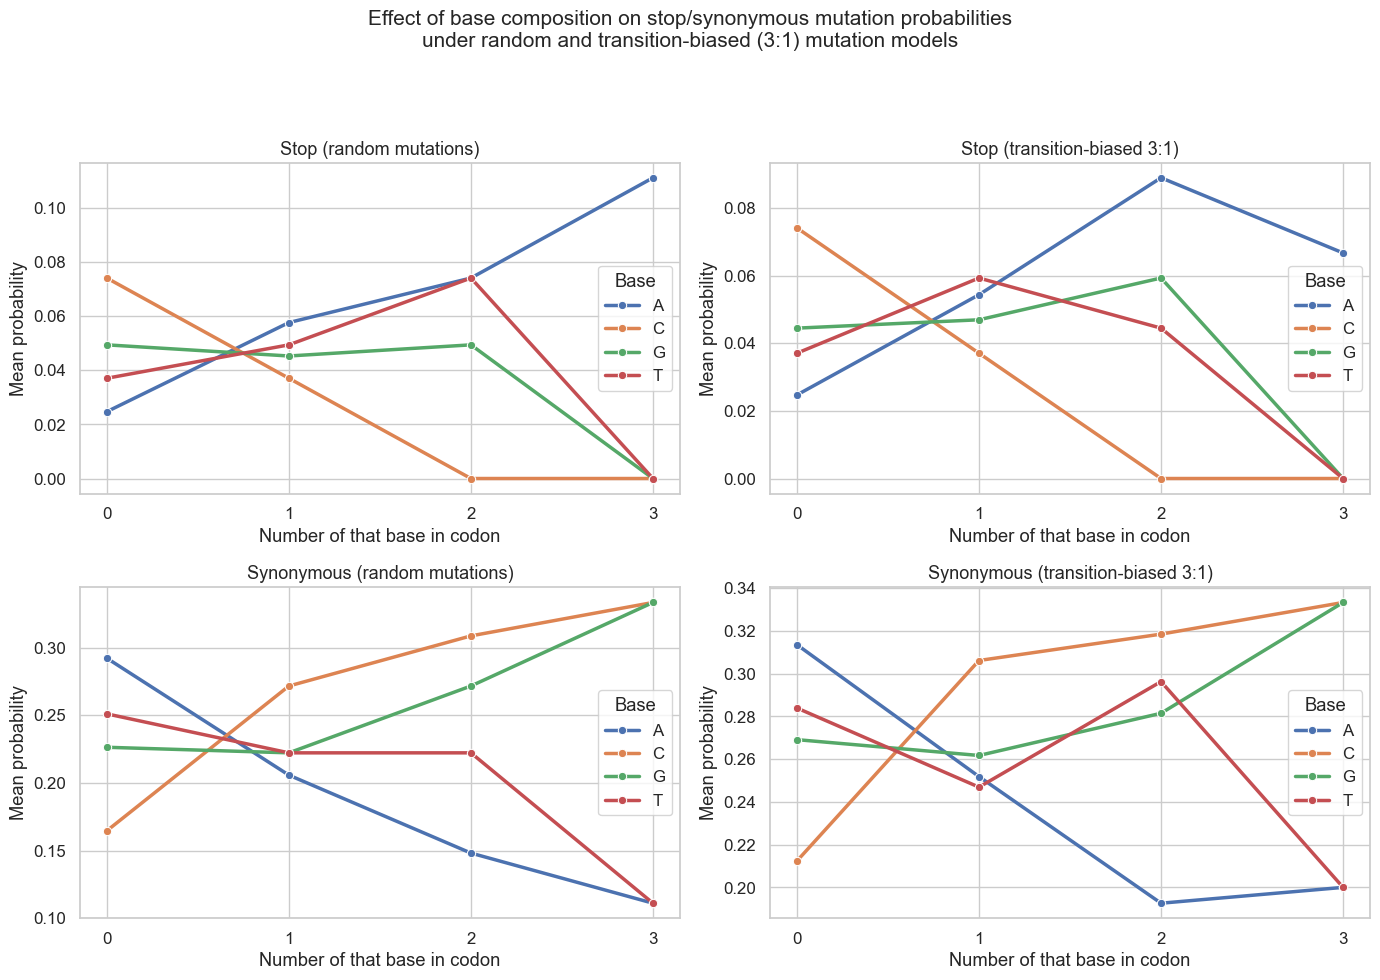

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- assumes df exists from your previous codon analysis ---

# Compute how many of each base (A,C,G,T) appear in each codon
for base in ["A", "C", "G", "T"]:
    df[f"n_{base}"] = df["codon"].str.count(base)

# Helper function: summarize mean rates by base composition
def summarize_by_base(metric, model_label, category):
    """Return tidy dataframe for plotting: mean rate by base, base count, model, and mutation type."""
    summaries = []
    for base in ["A", "C", "G", "T"]:
        grouped = df.groupby(f"n_{base}")[metric].mean().reset_index()
        grouped["base"] = base
        grouped.rename(columns={f"n_{base}": "count", metric: "mean_rate"}, inplace=True)
        grouped["model"] = model_label
        grouped["type"] = category
        summaries.append(grouped)
    return pd.concat(summaries, ignore_index=True)

# Build all 4 tables (stop/syn × uniform/weighted)
stop_uniform = summarize_by_base("uniform_stop_rate", "Uniform (random)", "Stop")
stop_weighted = summarize_by_base("wt_stop_rate_ti3_tv1", "Transition-biased (3:1)", "Stop")
syn_uniform = summarize_by_base("uniform_syn_rate", "Uniform (random)", "Synonymous")
syn_weighted = summarize_by_base("wt_syn_rate_ti3_tv1", "Transition-biased (3:1)", "Synonymous")

# Combine
df_all = pd.concat([stop_uniform, stop_weighted, syn_uniform, syn_weighted])

# --- PLOT 4 LINE CHARTS ---

sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)

plot_map = [
    ("Stop", "Uniform (random)", axes[0, 0], "Stop (random mutations)"),
    ("Stop", "Transition-biased (3:1)", axes[0, 1], "Stop (transition-biased 3:1)"),
    ("Synonymous", "Uniform (random)", axes[1, 0], "Synonymous (random mutations)"),
    ("Synonymous", "Transition-biased (3:1)", axes[1, 1], "Synonymous (transition-biased 3:1)")
]

for ptype, model, ax, title in plot_map:
    subset = df_all[(df_all["type"] == ptype) & (df_all["model"] == model)]
    sns.lineplot(
        data=subset,
        x="count", y="mean_rate", hue="base",
        marker="o", linewidth=2.5, ax=ax
    )
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Number of that base in codon")
    ax.set_ylabel("Mean probability")
    ax.set_xticks([0, 1, 2, 3])
    ax.legend(title="Base")

plt.suptitle(
    "Effect of base composition on stop/synonymous mutation probabilities\n"
    "under random and transition-biased (3:1) mutation models",
    fontsize=15
)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
